In [378]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [6]:
RAW_PATH = '../data/raw/'

In [79]:
def batches(data, batch_size=60):
    """Return data in batches"""
    start = 0
    size = len(data) // batch_size + 1
    
    for i in range(size):
        yield data.iloc[start: start + 60]
        start += 60

In [465]:
def preprocess_to_image(data, label):
    """This function takes activity data of a patient and turns it into a rows and columns. The rows indicates hours (0 - 23)
    while the columns represents minutes(0 - 60)"""
    final_data, day_data = [], []
    labels = []

    hour = 1
    for batch in batches(data):
        if hour == 24:
            hour = 1
            final_data.append(np.array(day_data).T)
            labels.append(label)
            day_data = []
        hour += 1
        
        activity = batch['activity'].values
        day_data.append(activity)
        
    return final_data, labels

In [285]:
def remove_invalid_data(data):
    """Detects if there is 720 strings of zero and remove them from the dataset"""

    for idx, _ in data.iterrows():
        if (len(data.loc[idx: idx + 719, 'activity']) == 720) and (sum(data.loc[idx: idx + 719, 'activity']) == 0):
            return data.iloc[0: idx, :]

    return data

In [543]:
def read_data(path, n_classes=2):
    dirs = os.listdir(path)
    data, labels = [], []
    count = 1
    
    for d in dirs:
        if os.path.isdir(path + d): 
            print(f'{len(os.listdir(path + d))} files found in {d} directory' )
            for filename in os.listdir(path + d):
                activity_data = remove_invalid_data(pd.read_csv(f'{path}{d}/{filename}', parse_dates=['timestamp']))
                activity_data['activity'] = np.log(activity_data['activity'] + 1)
                activity_data['activity'] = activity_data['activity'].fillna(-1)
                image_data, image_label = preprocess_to_image(activity_data, label=n_classes - count)
                data.extend(image_data)
                labels.extend(image_label)
            count += 1
                
    return np.array(data), np.array(labels)

In [544]:
data, labels = read_data(RAW_PATH)
data = data.astype(np.float32) # convert the data to floating point numbers for normalization to be possible

20 files found in condition directory
27 files found in control directory


In [587]:
data.shape, labels.shape

((800, 60, 23, 1), (800,))

In [469]:
def normalize(data):
    maximum = data.max()
    return data / maximum

In [549]:
data_copy = data.copy()

In [586]:
data = data_copy.copy()

In [488]:
def sigmoid(x):
    e = np.exp(1)
    return 1/(1+e**(-x))

In [489]:
for idx, d in enumerate(data):
    data[idx] = sigmoid(d)

In [592]:
def show_image(data, label):
    """Display activity image"""
    fig, ax = plt.subplots(1,1, figsize=(12, 8))
    ax.imshow(data)
    if label == 0:
        label = 'control'
    else:
        label = 'condition'
        
    plt.title(label)
    plt.show()
    fig.savefig('control.jpg', dpi=82)

In [588]:
data[idx].shape

(60, 23, 1)

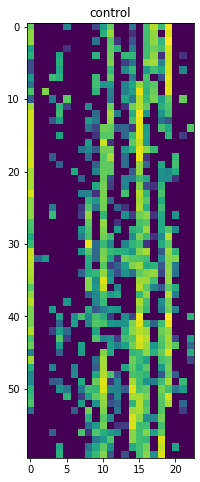

In [595]:
idx = 650
show_image(data[idx], labels[idx])

In [552]:
data = data.reshape(data.shape + (1,))

In [553]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=.2, random_state=42)

In [568]:
class_weight = {
    1: 1,
    0: 2,
}

In [569]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=[60, 23, 1]),
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_115 (Conv2D)         (None, 58, 21, 16)        160       
                                                                 
 conv2d_116 (Conv2D)         (None, 56, 19, 16)        2320      
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 28, 9, 16)        0         
 g2D)                                                            
                                                                 
 batch_normalization_35 (Bat  (None, 28, 9, 16)        64        
 chNormalization)                                                
                                                                 
 dropout_73 (Dropout)        (None, 28, 9, 16)         0         
                                                                 
 conv2d_117 (Conv2D)         (None, 26, 7, 32)       

In [570]:
model.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(0.0001),
             metrics=['accuracy'])

model.fit(X_train, y_train, epochs=30)

Epoch 1/30
20/20 [==============================] - 2s 81ms/step - loss: 0.9966 - accuracy: 0.5453
Epoch 2/30
20/20 [==============================] - 2s 80ms/step - loss: 0.9360 - accuracy: 0.5688
Epoch 3/30
20/20 [==============================] - 2s 81ms/step - loss: 0.9078 - accuracy: 0.5844
Epoch 4/30
20/20 [==============================] - 2s 82ms/step - loss: 0.8662 - accuracy: 0.6031
Epoch 5/30
20/20 [==============================] - 2s 82ms/step - loss: 0.8893 - accuracy: 0.5813
Epoch 6/30
20/20 [==============================] - 2s 85ms/step - loss: 0.8455 - accuracy: 0.5859
Epoch 7/30
20/20 [==============================] - 2s 89ms/step - loss: 0.8060 - accuracy: 0.6078
Epoch 8/30
20/20 [==============================] - 2s 99ms/step - loss: 0.7835 - accuracy: 0.6500
Epoch 9/30
20/20 [==============================] - 2s 84ms/step - loss: 0.7454 - accuracy: 0.6547
Epoch 10/30
20/20 [==============================] - 2s 85ms/step - loss: 0.7325 - accuracy: 0.6516
Epoch 11/

In [571]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 24ms/step - loss: 0.6829 - accuracy: 0.7063


[0.6829465627670288, 0.706250011920929]

In [573]:
pd.DataFrame(y_test).value_counts(normalize=True)

0    0.625
1    0.375
dtype: float64

In [574]:
y_test

array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0])

In [575]:
prediction = np.round(model.predict(X_test))

In [565]:
from sklearn.metrics import plot_confusion_matrix, classification_report

In [576]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.74      0.81      0.78       100
           1       0.63      0.53      0.58        60

    accuracy                           0.71       160
   macro avg       0.69      0.67      0.68       160
weighted avg       0.70      0.71      0.70       160

